# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Homework 6: Trees, Bagging, Random Forests, and Boosting


**Harvard University**<br/>
**Fall 2021**<br/>
**Instructors**: Pavlos Protopapas and Natesh Pillai

<hr style="height:2pt">



In [1]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

### Import Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample

# pandas tricks for better display
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

%matplotlib inline

<a id="instructions"></a>

<hr style="height:2pt">

### INSTRUCTIONS

- **THIS IS AN INDIVIDUAL ASSIGNMENT. Collaboration on this homework IS NOT PERMITTED.**

- To submit your assignment follow the instructions given in Canvas.

- Please **restart the kernel and run the entire notebook again before you submit.**

- Running cells out of order is a common pitfall in Jupyter Notebooks. To make sure your code continues to work, restart the kernel and rerun your notebook periodically while working through this assignment. 

- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. **Please use only the libraries provided in those imports.**

- Please use `.head(...)` when viewing data. Do not submit a notebook that is **excessively long**. 

- In questions that require code to answer, such as "calculate and report $R^2$", do not just output the value from a cell. Write a `print(...)` function that clearly labels the output, includes a reference to the calculated value, and rounds it to a reasonable number of digits. **Do not hard code values in your printed output**. For example, this is an appropriate print statement:
```python
print(f'The R^2 is {R:.4f}')
```
- **Your plots MUST be clearly labeled and easy to read,** including clear labels for the $x$ and $y$ axes, a descriptive title ("MSE plot" is NOT a descriptive title; "95% confidence interval of coefficients for degree-5 polynomial model" on the other hand is descriptive), a legend when appropriate, and clearly formatted text and graphics.

- **Your code may also be evaluated for efficiency and clarity.** As a result, correct output is not always sufficient for full credit.

<hr style="height:2pt">

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Decision Tree [14 pts]**](#part1)
  - [Solutions](#part1solutions)


- [**Question 2: Bagging [27 pts]**](#part2) 
  - [Solutions](#part2solutions)


- [**Question 3: Random Forests [14 pts]**](#part3) 
  - [Solutions](#part3solutions)


- [**Question 4: Boosting [30 pts]**](#part4) 
  - [Solutions](#part4solutions)


- [**Question 5: Understanding [15 pts]**](#part5) 
  - [Solutions](#part5solutions)
  
  

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)


### Higgs boson discovery

The discovery of the Higgs boson in July 2012 marked a fundamental breakthrough in particle physics. The Higgs boson particle was discovered through experiments at the Large Hadron Collider at CERN, by colliding beams of protons at high energy. A key challenge in analyzing the results of these experiments is to differentiate between collisions that produce Higgs bosons and collisions that produce only background noise. 

### Data description

You are provided with data from Monte-Carlo simulations of collisions of particles in a particle collider experiment. The training set is available in `Higgs_train.csv` and the test set is in `Higgs_test.csv`. Each row in these files corresponds to a particle collision described by 28 features (columns 1-28), of which the first 21 features are kinematic properties measured by the particle detectors in the accelerator, and the remaining features are derived by physicists from the first 21 features. The class label is provided in the last column, with a label of 1 indicating that the collision produces Higgs bosons (signal), and a label of 0 indicating that the collision produces other particles (background).

The data set provided to you is a small subset of the HIGGS data set in the UCI machine learning repository. The following paper contains further details about the data set and the predictors used: [Baldi et al., Nature Communications 5, 2014](https://www.nature.com/articles/ncomms5308).

### Loading the data

Run the following cell to load the data. Do not modify this code. We need to ensure everyone has the exact same arrays for this homework.

In [3]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

data_train = pd.read_csv("data/Higgs_train.csv")
data_test = pd.read_csv("data/Higgs_test.csv")

print(
    f"Our data contains {len(data_train):,} training samples "
    f"and {len(data_test):,} test samples.\n"
)

print("TRAINING DATA INFORMATION:\n")
data_train.info()

print("\nTRAINING DATA HEAD:")
display(data_train.head())

print("\nTRAINING DATA SUMMARY STATISTICS:")
display(data_train.describe())

# Split dataframe into X and y numpy arrays
X_train = data_train.iloc[:, data_train.columns != "class"].values
y_train = data_train["class"].values
X_test = data_test.iloc[:, data_test.columns != "class"].values
y_test = data_test["class"].values

Our data contains 5,000 training samples and 5,000 test samples.

TRAINING DATA INFORMATION:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lepton pT                 5000 non-null   float64
 1   lepton eta                5000 non-null   float64
 2   lepton phi                5000 non-null   float64
 3   missing energy magnitude  5000 non-null   float64
 4   missing energy phi        5000 non-null   float64
 5   jet 1 pt                  5000 non-null   float64
 6   jet 1 eta                 5000 non-null   float64
 7   jet 1 phi                 5000 non-null   float64
 8   jet 1 b-tag               5000 non-null   float64
 9   jet 2 pt                  5000 non-null   float64
 10  jet 2 eta                 5000 non-null   float64
 11  jet 2 phi                 5000 non-null   float64
 12  jet 2 b-tag             

,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
0,0.377,-1.5800,-1.7100,0.991,0.114,1.250,0.620,-1.480,2.17,0.754,0.7750,-0.667,2.21,1.280,-1.190,0.505,0.00,1.110,-0.464,0.397,0.00,0.522,1.320,0.982,1.360,0.965,1.310,1.080,1.0
1,0.707,0.0876,-0.4000,0.919,-1.230,1.170,-0.553,0.886,2.17,1.300,0.7620,-1.060,2.21,0.607,0.459,1.020,0.00,0.497,0.956,0.236,0.00,0.440,0.829,0.992,1.160,2.220,1.190,0.938,1.0
2,0.617,0.2660,-1.3500,1.150,1.040,0.955,0.377,-0.148,0.00,1.060,-0.0194,1.110,0.00,1.470,0.205,-1.060,2.55,1.490,-0.398,-0.542,0.00,1.020,1.030,0.986,0.928,1.370,0.982,0.917,1.0
3,0.851,-0.3810,-0.0713,1.470,-0.795,0.692,0.883,0.497,0.00,1.620,0.1240,1.180,1.11,1.290,0.160,-0.916,2.55,0.945,0.796,-1.520,0.00,1.200,1.100,0.987,1.350,1.460,0.995,0.954,1.0
4,0.768,-0.6920,-0.0402,0.615,0.144,0.749,0.397,-0.874,0.00,1.150,0.1270,1.320,2.21,0.730,-0.758,-1.120,0.00,0.848,0.107,0.502,1.55,0.922,0.864,0.983,1.370,0.601,0.919,0.957,0.0



TRAINING DATA SUMMARY STATISTICS:


,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,jet 2 pt,jet 2 eta,jet 2 phi,jet 2 b-tag,jet 3 pt,jet 3 eta,jet 3 phi,jet 3 b-tag,jet 4 pt,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,class
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.978645,-0.014280,-0.018956,1.005793,0.002528,0.980390,0.025014,-0.007104,0.993678,0.988659,-0.010310,-0.006926,1.006922,0.997004,0.018817,0.003952,1.011994,0.982806,0.005201,0.003349,1.007810,1.038431,1.027201,1.054719,1.023094,0.958464,1.033432,0.960494,0.524600
std,0.547025,1.011927,0.997945,0.591907,1.003337,0.463677,1.002018,1.014559,1.028920,0.476462,1.007983,1.002177,1.045206,0.471681,1.007824,0.999656,1.200416,0.497681,1.007999,1.008904,1.400846,0.619460,0.353984,0.173243,0.427141,0.495720,0.352966,0.306057,0.499444
min,0.275000,-2.410000,-1.740000,0.010000,-1.740000,0.170000,-2.920000,-1.740000,0.000000,0.198000,-2.910000,-1.740000,0.000000,0.265000,-2.720000,-1.740000,0.000000,0.366000,-2.500000,-1.740000,0.000000,0.151000,0.443000,0.339000,0.371000,0.079500,0.413000,0.452000,0.000000
25%,0.587000,-0.764250,-0.877500,0.581000,-0.870000,0.676000,-0.659250,-0.885000,0.000000,0.666000,-0.699000,-0.859500,0.000000,0.664750,-0.679250,-0.858000,0.000000,0.619000,-0.707250,-0.869250,0.000000,0.798750,0.850000,0.986000,0.768000,0.672000,0.826000,0.772750,0.000000
50%,0.846000,-0.009305,-0.016050,0.903500,0.001300,0.891000,0.049500,-0.023500,1.090000,0.891000,-0.004800,-0.030700,1.110000,0.899500,0.045700,0.018800,0.000000,0.877000,0.012900,-0.004700,0.000000,0.898000,0.957000,0.990000,0.922000,0.868000,0.952000,0.877500,1.000000
75%,1.220000,0.725500,0.837000,1.300000,0.866000,1.160000,0.716000,0.894000,2.170000,1.192500,0.692250,0.855500,2.210000,1.232500,0.717000,0.855000,2.550000,1.220000,0.719000,0.859000,3.100000,1.030000,1.090000,1.030000,1.160000,1.120000,1.140000,1.060000,1.000000
max,5.330000,2.430000,1.740000,6.260000,1.740000,4.190000,2.960000,1.740000,2.170000,4.800000,2.910000,1.740000,2.210000,4.630000,2.730000,1.740000,2.550000,5.770000,2.490000,1.740000,3.100000,10.600000,5.740000,3.940000,6.220000,5.080000,4.320000,3.500000,1.000000


<a id="part1"></a>

## <div class='exercise'>Question 1: Decision Tree [14 pts]</div> 
    
[Return to contents](#contents)
    
We will start by fitting a basic model that will serve as our "baseline" (i.e. a simple model that we can use as a starting point and can reasonably compare to other models). We will use a decision tree as our baseline model. We will later compare bagging, random forests, and boosting models in subsequent questions. We want a fair comparison, so it is important to keep important aspects of the experiments consistent (e.g. the data used to report train and test scores). We will tune the decision tree using cross-validation (of course). The hyper-parameter we will tune is the "maximum tree depth", which we will refer to as "depth" for simplicity.

Since we will only use tree-based methods in this homework, we do not need to scale our predictor or response variables. 

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set, while storing the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds`, respectively.

Now that we have these informative scores, let us plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.
    
**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracies on the train and test set. Store the train and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

**1.3** In terms of the bias-variance tradeoff, how does limiting tree depth avoid over-fitting? What is one downside of limiting the tree depth? 


<a id="part1solutions"></a>

## Question 1: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**1.1** In this problem, we will observe how both tree-depth and cross-validation affect our ability to accurately model data. Specifically, for each tree depth from 1 to 20 (inclusive):

- Fit a decision tree to the entire **training** set.

- Evaluate on the entire **training** set (i.e., `.score(...)`), while storing the scores in a variable named `train_scores`.

- Perform 5-fold cross-validation with the entire **training** set, while storing the mean validation score and the validation standard deviation  in variables named `cvmeans` and `cvstds`, respectively.

Now that we have these informative scores, let us plot them. Generate 2 plots, both showing (a) the non-cross-validation training scores, (b) the mean validation scores, and (c) a shaded region that illustrates the +/-2 standard deviation validation bounds for each tree depth. The content and formatting of these 2 plots should be identical, EXCEPT in one plot set the limits on the y-axis to focus on the validation performance. Remember to label and title each plot appropropriately.

**HINT:** You can use `plt.fill_between(...)` to easily generate the shaded region in your plots.

</div>

In [18]:
# your code here 

train_scores = {}
cvmeans = {}
cvstds = {}

tree_depth_start, tree_depth_end = 1, 20
for i in range(tree_depth_start, tree_depth_end + 1):
    
    #declare tree model object
    model = DecisionTreeClassifier(max_depth=i)
    
    #fit the decision tree to the entire training set
    model.fit(X_train, y_train)
    
    #Evaluate on the entire training set (i.e., .score(...)), while storing the scores in a variable named train_scores.
    train_scores[i] = model.score(X_train, y_train)
    
    #get cv metrics
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
    cvmeans[i] = scores.mean()
    cvstds[i] = np.std(scores)

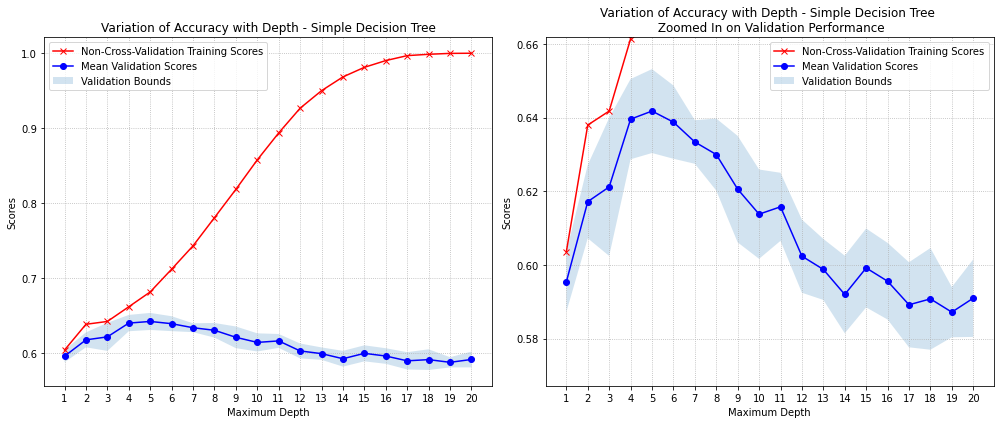

In [31]:
#Plot helpers
lists_train_scores = sorted(train_scores.items())
x_train_scores, y_train_scores = zip(*lists_train_scores)   

lists_cvmeans = sorted(cvmeans.items())
x_cvmeans, y_cvmeans = zip(*lists_cvmeans)   

stds = np.array([ scores for scores in cvstds.values() ])

#Plot
f, axes = plt.subplots(1,2, figsize=(14,6))

axes[0].plot(x_train_scores, y_train_scores, 'r-', marker='x', label="Non-Cross-Validation Training Scores")
axes[0].plot(x_cvmeans, y_cvmeans, 'b-', marker='o', label="Mean Validation Scores")
axes[0].fill_between(x_cvmeans, y_cvmeans + stds, y_cvmeans - stds, alpha=0.2, label="Validation Bounds")
axes[0].legend()
axes[0].set_title('Variation of Accuracy with Depth - Simple Decision Tree')
axes[0].set_ylabel("Scores")
axes[0].set_xlabel("Maximum Depth")
axes[0].set_xticks(x_train_scores)
axes[0].grid(ls=":")

axes[1].plot(x_train_scores, y_train_scores, 'r-', marker='x', label="Non-Cross-Validation Training Scores")
axes[1].plot(x_cvmeans, y_cvmeans, 'b-', marker='o', label="Mean Validation Scores")
axes[1].fill_between(x_cvmeans, y_cvmeans + stds, y_cvmeans - stds, alpha=0.2, label="Validation Bounds")
axes[1].legend()
axes[1].set_title('Variation of Accuracy with Depth - Simple Decision Tree \n Zoomed In on Validation Performance')
axes[1].set_ylabel("Scores")
axes[1].set_xlabel("Maximum Depth")
axes[1].set_ylim([min(cvmeans.values())-.02, max(cvmeans.values())+.02])
axes[1].set_xticks(x_train_scores)
axes[1].grid(ls=":")

plt.tight_layout()
plt.show()

<div class='exercise-r'>

**1.2** Using the cross-validation experiments from above, select a depth you deem most appropriate for using on future, unseen data, and justify your choice. Then, using this depth, report the classification accuracies on the train and test set. Store the train and test accuracies in variables named `best_cv_tree_train_score` and `best_cv_tree_test_score`, respectively, which we will refer to in later questions.

</div>

In [36]:
# your code here
#Find the best depth
best_depth = max(cvmeans, key=cvmeans.get)
print("The best depth is: ", best_depth)

#declare tree model object
model = DecisionTreeClassifier(max_depth=best_depth)

#fit the decision tree to the entire training set
model.fit(X_train, y_train)

best_cv_tree_train_score = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
best_cv_tree_test_score = cross_val_score(estimator=model, X=X_test, y=y_test, cv=5, n_jobs=-1)

print(f'The classification accuracy of the TRAIN set is: {best_cv_tree_train_score.mean():.4f}')
print(f'The classification accuracy of the TEST set is: {best_cv_tree_test_score.mean():.4f}')

The best depth is:  5
The classification accuracy of the TRAIN set is: 0.6428
The classification accuracy of the TEST set is: 0.6520


**I chose a depth of 5 as it has the highest mean validation score.**

<div class='exercise-r'>

**1.3** In terms of the bias-variance tradeoff, how does limiting tree depth avoid over-fitting? What is one downside of limiting the tree depth?

</div>

**Limiting tree depth increases our bias but decreases our variance. This helps us avoid over-fitting because an over-fitted model generally has low bias and high variance. However, by limiting the tree depth we can potentially increase our bias too much and then underfit.**

<a id="part2"></a>

## <div class='exercise'>Question 2: Bagging [27 pts]</div> 

[Return to contents](#contents)

Bagging is the technique of building the same model on multiple bootstrap samples from the data and combining each model's prediction to get an overall classification. In this question, we build an example by hand and study how the number of bootstrapped datasets impacts the resulting classification accuracy.


**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- First, complete the `bagger` function based on the function's signature and docstring provided in the code cell below.
- Then, make a single call to that function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**REQUIRED DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps should be returned by the `bagger` function as dataframes formatted like the example shown below. Each row should represent one observation (from either the training or test set depending on the dataframe), and each column should represent one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

As an example, the required structure of the `bagging_train_df` and `bagging_test_df` dataframes is:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

**HINT:** You can use `resample(...)` from scikit-learn to easily bootstrap the $X$ and $y$ data.

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`. What accuracy does this "bagging" model achieve on the training and test sets? Using Python's `assert` keyword, write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in [Question 1](#part1solutions).

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.

**2.7** In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

<a id="part2solutions"></a>

## Question 2: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**2.1** Based on your results from [Question 1](#part1solutions), choose a tree depth that WILL overfit the training set. What evidence leads you to believe that this depth overfits? Assign your choice to a variable named `tree_depth`. (You may want to explore different settings for this value in the problems below. However, be certain that your final choice and rationale is based on your results from Question 1.)

</div>

In [37]:
# your code here
tree_depth = 19

**I chose a depth of 19 as this resulted in the lowest mean validation score while simultaneously having the highest non-cross validated training score. This tells me that the model is significantly overfitting on the training set.**

<div class='exercise-r'>

**2.2** Here we will use the `tree_depth` chosen in Question 2.1 to generate 55 boostrapped sets of decision tree predictions for both the training and test data. To accomplish this:

- First, complete the `bagger` function based on the function's signature and docstring provided in the code cell below.
- Then, make a single call to that function to return your bootstrapped results.
- Store your returned results as: 
  1. `bagging_train_df`: a dataframe containing your training data predictions (see the "required dataframe structure" below)
  2. `bagging_test_df`: a dataframe containing your test data predictions
  3. `bagging_models_list`: a list containing your 55 fitted model objects (i.e. fitted estimators)
- Finally, display the heads of both dataframes.

**NOTE:** There is no need to do anything with your `bagging_models_list` list yet. It will not be used until later in [Question 3.2](#part3).

**REQUIRED DATAFRAME STRUCTURE:** The training and test prediction results of your bootstraps should be returned by the `bagger` function as dataframes formatted like the example shown below. Each row should represent one observation (from either the training or test set depending on the dataframe), and each column should represent one bootstrapped result. The values stored in the dataframe are the bootstrapped predictions for each observation as illustrated below.

As an example, the required structure of the `bagging_train_df` and `bagging_test_df` dataframes is:

|     |bootstrap model 1|bootstrap model 2|...|bootstrap model 55|  
| --- | --- | --- | --- | --- |
|0| 0 | 1|... |0|
|1| 1| 1|... |0|
|2| 0| 0|... |1|
|...| ...| ...|... |... |
| $n$-1 | 0| 0|... |1|

**HINT:** You can use `resample(...)` from scikit-learn to easily bootstrap the $X$ and $y$ data.

</div>

In [ ]:
# Complete this function as instructed
# Do not modify the function signature or docstring
def bagger(
    n_trees: int,
    tree_depth: int,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_test: np.ndarray,
    random_seed: int = 0,
) -> (pd.DataFrame, pd.DataFrame, list):
    """Generate boostrapped DecisionTreeClassifier predictions
    
    Function fits bootstrapped DecisionTreeClassifier models
    and returns training and test predictions for each of those
    bootstrapped models, along with the fitted model objects as
    described in Question 2.2 question text.
    
    :param n_trees: int, number of bootstrapped decision trees
    :param tree_depth: int, maximum tree depth
    :param X_train: np.ndarray, training X observations
    :param y_train: np.ndarray, training y observations
    :param X_test: np.ndarray, test X observations
    :param random_seed: int, random seed used to set np.random.seed
                        to ensure replicable results (default=0)
    
    :returns: (pd.DataFrame, pd.DataFrame, list), tuple containing 3
              objects, (1) bagging_train_df dataframe
              as described in Q2.2 question text, (2) bagging_test_df
              dataframe as described in Q2.2, and (3) bagging_models_list
              containing every trained DecisionTreeClassifier model
              object (i.e. estimator), one estimator for each bootstrap
              (you will need this list later in Q3.2)
    """
    # your code here
    
    #Creating model
    np.random.seed(0)
    model = DecisionTreeClassifier(max_depth=tree_depth)

    #Initializing variables
    predictions_train = np.zeros( shape = (data_train.shape[0], n_trees))
    predictions_test  = np.zeros( shape = (data_test.shape[0],  n_trees))

    #Conduct bootstraping iterations
    for i in range(n_trees):
        temp = data_train.sample(frac=1, replace=True)
        boot_y = temp['Spam']
        boot_X = temp.drop(['Spam'], axis=1)

        model.fit(boot_X, boot_y)  
        predictions_train[:,i] = model.predict(x_train)   
        predictions_test[:,i] = model.predict(x_test)

    #Make Predictions Dataframe
    columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
    bagging_train_df = pd.DataFrame(predictions_train, columns=columns)
    bagging_test_df = pd.DataFrame(predictions_test, columns=columns)

    
    # end of your code here
    
    return bagging_train_df, bagging_test_df, bagging_models_list
     

In [ ]:
# your code here


<div class='exercise-r'>

**2.3**  Aggregate all 55 bootstrapped models to get a combined prediction for each training and test observation (i.e. predict a `1` if, and only if, a majority of the models predict that observation to be from class 1). Assign the bagging train and test accuracies to variables named `bagging_accuracy_train` and `bagging_accuracy_test`. What accuracy does this "bagging" model achieve on the training and test sets? Using Python's `assert` keyword, write an assertion that verifies that this test set accuracy is at least as good as the accuracy for the model you fit in [Question 1](#part1solutions).

**HINT:** You can use `np.mean(...)` to easily test for majority. If a majority of models vote 1, consider what that implies about the mean.

</div>

In [ ]:
# your code here


<div class='exercise-r'>

**2.4** We want to know how the number of bootstraps affects our bagging ensemble's performance. Use the `running_predictions(...)` function provided below to get the model's accuracy score when using only $j$ of the bootstrapped models, where $j \in [1, 2, 3, ..., 55]$. Using the `tree_depth` chosen in Question 2.1, make a plot that illustrates the accuracy on the training set and test set at each number of bootstraps (varying $j$ from 1 to 55). Please see the `running_predictions` signature and docstring regarding the use of the function. You should be able to use your `bagger`-generated dataframes from Q2.2 as an input to this function.

On your plot, in addition to the training and test accuracies at each value $j$, also include horizontal lines for two baseline comparisons:

1. The test accuracy of the best model from [Question 1](#part1solutions);
2. The test accuracy of a single decision tree with the overfit `tree_depth` you chose in Question 2.1, trained on the full training set.

</div>

In [ ]:
# RUN THIS CELL
# DO NOT MODIFY THIS CODE

def running_predictions(
    bagger_results_df: pd.DataFrame,
    targets: np.ndarray,
) -> pd.Series:
    """Generates running accuracy of intermediate bootstraps when bagging 
    
    Generates a series of accuracy scores calculated using the
    running predictions of each additional bootstrapped model
    generated using the Question 2.2 `bagger` function. For example,
    the first accuracy in the series represents the predictive
    accuracy of just the first bootstrapped model. The second accuracy
    reflects the bagged accuracy of the first 2 bootstrapped models. The
    j-th accuracy reflects the bagged accuracy of the first j
    bootstrapped models.
    
    :param bagger_results_df: pd.DataFrame, a bagging results dataframe
                              (either train or test) output from the Q2.2
                              `bagger` function
    :param targets: np.ndarray, 1-dimensional array of true class labels
                    for either train or test observations (i.e y_train or
                    y_test, whichever corresponds to the inputted
                    bagger_results_df)             
    :returns: pd.Series, a series of values showing the accuracy of
              using the initial j trees to predict the targets for each
              value of j bootstrapped models
    """
    # verify that input data objects meet the requirements specified
    # in the docstring
    assert type(bagger_results_df)==pd.core.frame.DataFrame, (
        "baggin_results_df input must be a pd.DataFrame"
    )
    assert type(targets)==np.ndarray, (
        "targets input must be an np.ndarray"
    )
    assert targets.ndim==1, (
        "targets input np.ndarray must be one-dimensional"
    )
    
    # identify the number of bootstrapped trees in inputted bagger df
    n_trees = bagger_results_df.shape[1]
    
    # calculate the running percentage of models voting 1 as each
    # additional model is considered
    running_percent_1s = (
        np.cumsum(bagger_results_df, axis=1)/np.arange(1,n_trees+1)
    )
    
    # predict 1 when the running average is above 0.5
    running_conclusions = running_percent_1s > 0.5
    
    # check whether the running predictions match the targets
    running_correctnesss = running_conclusions == targets.reshape(-1,1)
    
    # calculate and return final accuracies
    return np.mean(running_correctnesss, axis=0)


In [ ]:
# your code here


<div class='exercise-r'>

**2.5** Referring to your graph from 2.4, compare the performance of bagging against the baseline of a single `tree_depth` tree. Explain the differences you see.

</div>

**your answer here**

<div class='exercise-r'>

**2.6** Bagging and limiting tree depth both affect how much the model overfits. Compare and contrast these two approaches. Your answer should refer to your graph in 2.4 and may duplicate something you said in your answer to 2.5.

</div>

**your answer here**

<div class='exercise-r'>

**2.7** In what ways might our bagging classifier be overfitting the data? In what ways might it be underfitting?

</div>

**your answer here**

<a id="part3"></a>

## <div class='exercise'>Question 3: Random Forests [14 pts]</div> 

[Return to contents](#contents)

Random forests are closely related to the bagging model we built by hand in Question 2. In this question, we will compare our bagging results with the results of using scikit-learn's `RandomForestClassifier`.

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate and report this classifier's accuracy on the training and test sets. Then, assign those accuracies to the variables `random_forest_train_score` and `random_forest_test_score`.

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

**3.3**: Make a Pandas table (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |


<a id="part3solutions"></a>

## Question 3: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**3.1**  Fit a `RandomForestClassifier` to the original `X_train` data using the same tree depth and number of trees you used in Question 2.2, and set the maximum number of features to use when looking for the best split to be the square root of the total number of features. Evaluate and report this classifier's accuracy on the training and test sets. Then, assign those accuracies to the variables `random_forest_train_score` and `random_forest_test_score`.

</div>

In [ ]:
# your code here


<div class='exercise-r'>

**3.2** Among all of the decision trees you fit in the bagging process (i.e. each of the fitted model objects stored in `bagging_models_list`), how many times is each feature used as the top/first node? How about for each tree in the random forest you just fit? Assign the answers to these questions to two pandas Series called `top_predictors_bagging` and `top_predictors_rf`, and display them.

What about the process of training the Random Forest causes this difference? What implication does this observation have on the accuracy of bagging vs. random forest?

**HINT:** A decision tree's top feature is stored as `.tree_.feature[0]`. A random forest object stores its decision trees in its `.estimators_` attribute.

</div>

In [ ]:
# your code here


**your answer here**

<div class='exercise-r'>

**3.3**: Make a Pandas table (following the expected structure shown below) of the training and test accuracy for the following models and name it `results_df`:

1. Single tree with the best depth chosen by cross-validation (from Question 1)
2. A single overfit tree trained on all data (from Question 2, using the depth you chose there)
3. Bagging 55 such trees (from Question 2)
4. A random forest of 55 such trees (from Question 3.1)

Display your `results_df` dataframe and answer: What is the relative performance of each model on the training set? On the test set? Comment on how these relationships make sense (or don't make sense) in light of how each model treats the bias-variance tradeoff.

**NOTE:** This problem should not require fitting any new models, though you may need to go back and store the accuracies from models you fit previously.

The expected structure for `results_df` is:  

| classifier | training accuracy | test accuracy |
| --- |  --- | --- |
| single depth-$i$ tree chosen by CV | ... | ... |
| single overfit depth-$k$ tree | ... | ... |
| bagging 55 depth-$k$ trees | ... | ... |
| random forest of 55 depth-$k$ trees | ... | ... |

</div>

In [ ]:
# your code here


**your answer here**

<a id="part4"></a>

## <div class='exercise'>Question 4: Boosting [30 pts]</div> 

[Return to contents](#contents)

In this question, we explore a different kind of ensemble method, boosting. Each new model is trained on a dataset weighted towards observations that the current model predicts incorrectly. 

We will focus on the AdaBoost flavor of boosting and examine the ensemble model's accuracy as the algorithm adds more estimators (iterations) to the ensemble.

**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes:

- Fit `tree1`, a decision tree of depth-3, to the training data. 

- Report the train and test accuracies. 

- For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. 

- Do you notice any predictors for which the distributions are clearly different?
    
**HINTS:**
- The use of subplots using `plt.subplots(...)` will make this plotting exercise easier to code and will help you to present these visuals in a cleaner, easier to view manner.
- You may find [`sns.kdeplot(...)`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) useful for this exercise. If you do use it, please note from the Seaborn documentation that `sns.kdeplot` takes `ax` as a parameter.

**4.2** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

**4.3** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.2:

- Write an excellent example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**4.4** Now, let us use the scikit-learn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and test accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

**4.5** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. Therefore, you should end up with 4 separate plots or subplots. What trends do you see in the training and test accuracy?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

**4.6** Answer the following interpretive questions. The use of code is optional here, but should be used if you find it is needed to answer any of these questions. 


- **4.6.1** Based on the plots from Question 4.5, what combination of base learner depth and the number of iterations seems optimal and why? 


- **4.6.2** Why should we be hesitant to select our learner depth and number of iterations hyperparameters based on our inspection of these train and test results? What are the risks of doing so? 


- **4.6.3** Setting those risks aside, if you do select the base learner depth and number of iterations based on those plots, how does the performance of that model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?


<a id="part4solutions"></a>

## Question 4: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**4.1** We will motivate AdaBoost by noticing patterns in the errors that a single classifier makes:

- Fit `tree1`, a decision tree of depth-3, to the training data. 

- Report the train and test accuracies. 

- For each predictor, make a plot that compares two distributions: the values of that predictor for observations that `tree1` classifies correctly, and the values of that predictor for observations that `tree1` classifies incorrectly. 

- Do you notice any predictors for which the distributions are clearly different?
    
**HINTS:**
- The use of subplots using `plt.subplots(...)` will make this plotting exercise easier to code and will help you to present these visuals in a cleaner, easier to view manner.
- You may find [`sns.kdeplot(...)`](https://seaborn.pydata.org/generated/seaborn.kdeplot.html) useful for this exercise. If you do use it, please note from the Seaborn documentation that `sns.kdeplot` takes `ax` as a parameter.

</div>

In [ ]:
# your code here


**your answer here**

<div class='exercise-r'>

**4.2** The following code (see code cell below) "attempts" to implement a simplified version of boosting using just two classifiers. However, this implementation has both fuctionality AND stylistic flaws. Imagine that you are a grader for a college course in Data Science. Write a set of grading comments (in the provided Markdown cell) for the student who submitted this code. Point out the flaws in their provided code submission.

The intended functionality (i.e. expected requirements) of this "attempted" code is to accomplish the following:

1. Fit an initial tree with a maximum depth of 3.
2. Construct an array of sample weights that give a weight of 1 to samples that the initial tree classified correctly, and a weight of 2 to samples that the initial tree misclassified.
3. Fit a second depth-3 decision tree using those sample weights.
4. Predict by computing the probabilities that the initial tree and the second tree each assign to the positive class, then take the average of those two probabilities as the prediction probability.
5. Report the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

**NOTE:** Please do not modify anything in the code cell itself.

</div>

In [ ]:
# RUN THIS CELL
# "Attempted" boosting implementation

def boostmeup(X, y):
    tree = DecisionTreeClassifier(max_depth=3)
    tree1 = tree.fit(X, y)
    sample_weight = np.ones(len(X_train))
    q = 0
    for idx in range(len(X_train)):
          if tree1.predict([X_train[idx]]) != y_train[idx]:
             sample_weight[idx] = sample_weight[idx] * 2
             q = q + 1
    print("tree1 accuracy:", q / len(X_train))
    tree2 = tree.fit(X_train, y_train, sample_weight=sample_weight)
    
# Train
    q = 0
    for idx in range(len(X_train)):
        t1p = tree1.predict_proba([X_train[idx]])[0][1]
        t2p = tree2.predict_proba([X_train[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_train))

# Test
    q = 0
    for idx in range(len(X_test)):
        t1p = tree1.predict_proba([X_test[idx]])[0][1]
        t2p = tree2.predict_proba([X_test[idx]])[0][1]
        m = (t1p + t2p) / 2
        if m > .5:
            if y_train[idx] == True:
                q = q + 0
            else:
                q = q + 1
        else:
            if y_train[idx] == True:
                q = q + 1
            else:
                q = 0
    print("Boosted accuracy:", q / len(X_test))

boostmeup(X_train, y_train)

**your answer here**

<div class='exercise-r'>

**4.3** Now, imagine that you are the Teaching Fellow responsible for writing the "solutions" code for the simplified version of boosting using just two classifiers that had been "attempted" in Question 4.2:

- Write an excellent example implementation from scratch (i.e. using just scikit-learn's `DecisionTreeClassifier` and NumPy to perform your boosting). Your implementation should be written either [functionally](https://docs.python.org/3/tutorial/controlflow.html#defining-functions) or as a [class](https://docs.python.org/3/tutorial/classes.html), such that you can then call the function(s) or class methods to generate your predictions and/or accuracy scores.

- Report on the performance of your boosting algorithm by printing the training and test accuracies of just the initial tree, as well the training and test accuracies of the full 2-tree boosting ensemble.

</div>

In [ ]:
# your code here


<div class='exercise-r'>

**4.4** Now, let us use the scikit-learn implementation of AdaBoost: Use `AdaBoostClassifier` to fit another ensemble to `X_train`. Use a decision tree of depth-3 as the base learner, a learning rate 0.05, the default algorithm `SAMME.R`, and run the boosting for 800 iterations. Make a plot of the effect of the number of iterations on the model's train and test accuracy.

**HINT:** The `.staged_score(...)` method provides the accuracy numbers you'll need for plotting. You'll need to use `list(...)` to convert the "generator" that `staged_score` returns into an ordinary list.

</div>

In [ ]:
# your code here


<div class='exercise-r'>

**4.5** Repeat the plot above for a base learner with depths of 1, 2, 3, and 4. Therefore, you should end up with 4 separate plots or subplots. What trends do you see in the training and test accuracy?

**NOTE:** It is okay if your code re-fits the depth-3 classifier instead of reusing the results from the previous problem.

</div>

In [ ]:
# your code here


**your answer here**

<div class='exercise-r'>

**4.6** Answer the following interpretive questions. The use of code is optional here, but should be used if you find it is needed to answer any of these questions. 

</div>

In [ ]:
# your code here


<div class='exercise-r'>

**4.6.1** Based on the plots from Question 4.5, what combination of base learner depth and the number of iterations seems optimal and why?

</div>

**your answer here**

<div class='exercise-r'>

**4.6.2** Why should we be hesitant to select our learner depth and number of iterations hyperparameters based on our inspection of these train and test results? What are the risks of doing so?

</div>

**your answer here**

<div class='exercise-r'>

**4.6.3** Setting those risks aside, if you do select the base learner depth and number of iterations based on those plots, how does the performance of that model compare with the performance of the ensemble methods you considered in Question 2 and Question 3?

</div>

**your answer here**

<a id="part5"></a>

## <div class='exercise'>Question 5: Understanding [15 pts]</div> 

[Return to contents](#contents)

This question is intended to evaluate your overall knowledge and understanding of the current material. You may need to refer to lecture notes and other course materials to answer these questions.
    

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time? Why?

**5.5** Which of these techniques can be extended to regression tasks? How?

<a id="part5solutions"></a>

## Question 5: Solutions

[Return to contents](#contents)

<div class='exercise-r'>

**5.1** How do boosting and bagging relate: what is common to both, and what is unique to each?

</div>

**your answer here**

<div class='exercise-r'>

**5.2** Reflect on the overall performance of all of the different classifiers you have seen throughout this assignment. Which performed best? Why do you think that may have happened?

</div>

**your answer here**

<div class='exercise-r'>

**5.3** What is the impact of having too many trees in boosting and in bagging? In which instance is it worse to have too many trees?

</div>

**your answer here**

<div class='exercise-r'>

**5.4** Which technique, boosting or bagging, is better suited to parallelization, where you could have multiple computers working on a problem at the same time? Why?

</div>

**your answer here**

<div class='exercise-r'>

**5.5** Which of these techniques can be extended to regression tasks? How?

</div>

**your answer here**

#### THE END

[Return to contents](#contents)